# Data aggregation

### Load data

In [837]:
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [785]:
def load_data(data_name):
    pkl_file = open(data_name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [786]:
#  Load data and target

data_train = load_data('train_data')
two_matrix = load_data('two_matrix_200')
seq = load_data('FASTA')
data_features = pd.read_csv('pdb_and_features.csv')
data_features = data_features.reset_index(drop=True)

num_classes = 2

print(len(data_train))
print(len(two_matrix))

protein_len = []
pdb_200 = []

low_border = 25
high_border = 40

s = 0
for i in range(len(two_matrix)):
    if (np.shape(two_matrix[i][2])[0] <= high_border) and (np.shape(two_matrix[i][2])[0] >= low_border):
        s +=1

print('Amount of proteins, which we have after bounding: ', s)

8765
6905
Amount of proteins, which we have after bounding:  504


### Some information

In [788]:
length = []

for i in range(len(data_features['FASTA'])):
    
    if len(data_features['FASTA'][i]) <= high_border and len(data_features['FASTA'][i]) >= low_border:
        length.append(len(data_features['FASTA'][i]))

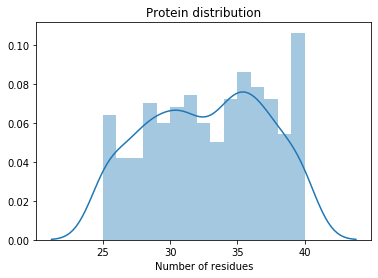

In [840]:
ax = sns.distplot(length, bins=15)
ax.set_title('Protein distribution')
ax.set_xlabel('Number of residues')
plt.savefig('protein_dis.png', dpi=300)

### Zero padding

In [790]:
#  Apply zero-padding to make same size for all train and target samples

target = []
mm = high_border

for i in range(len(two_matrix)):
    
    if (high_border >= np.shape(two_matrix[i][2])[0]) and (np.shape(two_matrix[i][2])[0] >= low_border):
        
        f = np.zeros((mm - np.shape(two_matrix[i][2])[0], np.shape(two_matrix[i][2])[0]))
        f1 = np.zeros((mm, mm - np.shape(two_matrix[i][2])[0]))
        bot = np.concatenate((two_matrix[i][2], f), axis=0)
        target.append([two_matrix[i][0], np.concatenate((bot, f1), axis=1), len(two_matrix[i][2])])
        

train = []
fasta = []
mm = high_border

for i in range(len(data_train)):
    
    if (high_border >= np.shape(data_train[i][1])[0]) and (len(data_features.FASTA[i]) <= high_border) and \
            (len(data_features.FASTA[i]) >= low_border):
        
        f = np.zeros((mm - np.shape(data_train[i][1])[0], np.shape(data_train[i][1])[1]))
        train.append([data_features.pdb_name[i], 
                      np.concatenate((data_train[i][1], f), axis=0), 
                      len(data_features.FASTA[i]),
                      data_features.FASTA[i]])
        
    elif (len(data_features.FASTA[i]) <= high_border) and (len(data_features.FASTA[i]) >= low_border):
        
        train.append([data_features.pdb_name[i], 
                      data_train[i][1][:mm], 
                      len(data_features.FASTA[i]), 
                      data_features.FASTA[i]])

In [791]:
np.shape(train), np.shape(target), np.shape(fasta)

((499, 4), (504, 3), (0,))

### Distance distribution

In [792]:
dist = []
dist_number = [0] * high_border

for i in range(len(target)):
    for j in range(high_border):
        for k in range(j + 1, high_border):
            
            if target[i][1][j][k] == 1:
                
                dist.append(k - j)
                dist_number[k - j] += 1

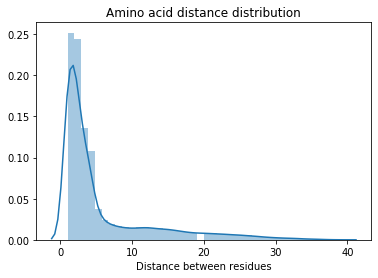

In [839]:
ax = sns.distplot(dist, bins = 40)

ax.set_title('Amino acid distance distribution')
ax.set_xlabel('Distance between residues')
plt.savefig('aminoacid_dis.png', dpi=300)

### train - target alignment

In [794]:
real_train = []
real_target = []

for i in range(len(target)):
    
    for j in range(len(train)):
        
        if train[j][0] == target[i][0]:
            real_train.append(train[j])
            real_target.append(target[i])
            
            break

In [795]:
np.shape(real_train), np.shape(real_target)

((486, 4), (486, 3), (0,))

## Statistical features

Features: affinity score matrix, length of each protein, distance between every amino acid

### Affinity score matrix

Affinity(a, b) = Contact(A, B) / (Contact(A, B) + NonContact(A, B))

separation distance $\geq$ 6

In [797]:
def affinity_matrix(seq, two_matrix):
    
    # 20 is the number of amino acids
    aa = {'A' : 0, 'C' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 
          'M' : 10, 'N' : 11, 'P' : 12, 'Q' : 13, 'R' : 14, 'S' : 15, 'T' : 16, 'V' : 17, 'W' : 18, 'Y' : 19}
    
    aff_matrix = [[0] * 20 for i in range(20)]
    matrix = [[0] * 20 for i in range(20)]
        
    if len(seq) != np.shape(two_matrix)[0]:
        return np.array(aff_matrix), np.array(matrix), 0
    
    for i in range(len(seq)):
        for j in range(i + 6, len(seq)):
            
            matrix[aa[seq[i]]][aa[seq[j]]] += 1
            matrix[aa[seq[j]]][aa[seq[i]]] += 1
                
            if two_matrix[i][j] == 1:
                
                aff_matrix[aa[seq[i]]][aa[seq[j]]] += 1
                aff_matrix[aa[seq[j]]][aa[seq[i]]] += 1
                
    return np.array(aff_matrix), np.array(matrix), 1


def get_probability(first, second, aff_matrix):
    
    aa = {'A' : 0, 'C' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 
      'M' : 10, 'N' : 11, 'P' : 12, 'Q' : 13, 'R' : 14, 'S' : 15, 'T' : 16, 'V' : 17, 'W' : 18, 'Y' : 19}
    
    return aff_matrix[aa[first]][aa[second]]

In [798]:
aff_matrix = [[0] * 20 for i in range(20)]
matrix = [[0] * 20 for i in range(20)]
count = 0

for i in range(len(real_train)):
    for j in range(len(two_matrix)):
        
        if real_train[i][0] == two_matrix[j][0]:
            
            aff, m, cnt = affinity_matrix(real_train[i][3], two_matrix[j][2])
            aff_matrix = np.add(aff_matrix, aff)
            matrix = np.add(matrix, m)
            count += cnt

The affinity score matrix

In [799]:
aff_matrix = np.divide(aff_matrix, matrix)

### Length of each protein

In [800]:
len_matrix = []

for i in range(len(real_train)):
    
    len_matrix.append([real_train[i][0], len(real_train[i][3])])

In [801]:
len_matrix[:5]

[['1CKZ', 25], ['1Y4E', 27], ['1LYP', 32], ['2K84', 30], ['1B9U', 34]]

delete

### train_test_split

In [802]:
train, train_val_test, train_label, target_val_test = train_test_split(real_train, real_target, test_size=0.3, random_state=13)
test, valid, test_label, valid_label = train_test_split(train_val_test, target_val_test, test_size=0.5, random_state=13)


In [770]:
np.shape(train), np.shape(test)

((340, 4), (73, 4))

In [841]:
test[34][0]

'1CBH'

### Train test transformations

"Train_transform" is for one dimensional features and "pairwise_train_transform" is for pairwise features

In [832]:
# Some transformations to make train and target data
# For neural networks

def redo(x):
    
    out = []
    for i in range(len(x)):
        out.append(x[i][1])
        
    return np.array(out)


def train_transform(x):
    
    x = redo(np.array(x))
    x = np.expand_dims(x, axis=4)
    
    return x
    

def reshape_of_labels(x):
    
    lst1 = [[[0 for col in range(x.shape[2])] for col in range(x.shape[0])] for row in range(x.shape[1])]
    for i in range(len(x)):
        for j in range(len(x[i])):
            for k in range(len(x[i][j])):
                lst1[j][i][k] = x[i, j, k]
                
    return lst1


def triangle_target_transform(x):
            
    res = []
    for i in range(x.shape[0]):
        res.append(x[i][1][np.triu_indices(len(x[i][1]), k = 1)])
    
    return np.array(res)

    
def target_transform(x):
    
    new_x = []
    x = triangle_target_transform(x)
    
    enc = OneHotEncoder(sparse = False)
    
    for i in range(len(x)):

        new_x.append(enc.fit_transform(x[i].reshape(-1, 1)))
        
    x = reshape_of_labels(np.array(new_x))
    
    return np.array(x)


def save_file(data, data_name):
    
    output = open(data_name + '.pkl', 'wb')
    pickle.dump(data, output)
    output.close()
    
    
def pairwise_train_transform(x, aff_matrix):
    
    out_matrix = []
    out = []
    dist = []
    
    for i in range(len(x)):
        out_matrix = []
        
        for j in range(len(x[i][1])):
            for k in range(j + 1, len(x[i][1])):
                
                if j < x[i][2] and k < x[i][2]:
                    pair = [k - j, get_probability(x[i][3][j], x[i][3][k], aff_matrix), len(x[i][3])]

                    out_matrix.append(np.concatenate([
                        x[i][1][j], 
                        x[i][1][k],
                        pair]))
                else:
                    pair = [0, 0, 0]

                    out_matrix.append(np.concatenate([
                        np.zeros(len(x[i][1][j])), 
                        np.zeros(len(x[i][1][k])),
                        pair]))
                     
        out.append(np.array(out_matrix))
            
    out = np.array(out)
    out = np.expand_dims(out, axis=4)
    
    return np.array(out)


def pairwise_target_transform(x):
    
    x = triangle_target_transform(x)
    
    return x

### Train data 

Pairwise features

In [826]:
def batch(iterable, n = 1):
    
    l = len(iterable)
    
    for ndx in range(0, l, n):
        
        yield iterable[ndx : min(ndx + n, l)]

pairwise_train = []
pairwise_test = []
pairwise_valid = []
        
for x in batch(train, 10):
    result = pairwise_train_transform(x, aff_matrix)
    
    for i in range(len(result)):
        pairwise_train.append(result[i])

for x in batch(test, 10):
    result = pairwise_train_transform(x, aff_matrix)
    
    for i in range(len(result)):
        pairwise_test.append(result[i])
    
for x in batch(valid, 10):
    result = pairwise_train_transform(x, aff_matrix)
    
    for i in range(len(result)):
        pairwise_valid.append(result[i])

<ipython-input-804-8683ede5e660>:108: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  out = np.expand_dims(out, axis=4)


One dimensional features

In [805]:
one_train = train_transform(train)
one_test = train_transform(test)
one_valid = train_transform(valid)

<ipython-input-804-8683ede5e660>:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  x = np.expand_dims(x, axis=4)


### Target data

In [827]:
def get_target(train_label, test_label, valid_label, model):
    
    if model == 'machine':
        
        pairwise_train_label = triangle_target_transform(np.array(train_label))
        pairwise_test_label = triangle_target_transform(np.array(test_label))
        pairwise_valid_label = triangle_target_transform(np.array(valid_label))
        
    elif model == 'neural':
        
        pairwise_train_label = target_transform(np.array(train_label))
        pairwise_test_label = target_transform(np.array(test_label))
        pairwise_valid_label = target_transform(np.array(valid_label))
        
    else:
        
        raise ValueError('No model type was found')
        
    return pairwise_train_label, pairwise_test_label, pairwise_valid_label

In [833]:
pairwise_train_label, pairwise_test_label, pairwise_valid_label = get_target(train_label,
                                                                            test_label, 
                                                                            valid_label, 
                                                                            'neural')

In [834]:
one_train_label, one_test_label, one_valid_label = get_target(train_label,
                                                                test_label, 
                                                                valid_label, 
                                                                'neural')

In [829]:
np.shape(pairwise_train), np.shape(pairwise_train_label)

((340, 780, 115, 1), (780, 340, 2))

In [808]:
np.shape(one_train), np.shape(one_train_label)

((340, 40, 56, 1), (780, 340, 2))

### Save files

In [830]:
def save(train, train_label, test, test_label, valid, valid_label):
    
    save_file(train, 'train')
    save_file(train_label, 'train_label')
    save_file(test, 'test')
    save_file(test_label, 'test_label')
    save_file(valid, 'valid')
    save_file(valid_label, 'valid_label')

In [812]:
save(one_train, one_train_label, one_test, one_test_label, one_valid, one_valid_label)

In [831]:
save(pairwise_train, pairwise_train_label, pairwise_test, pairwise_test_label, pairwise_valid, pairwise_valid_label)